In [1]:
import logging
import random
import torch
import numpy as np`
from torchvision import transforms
from federated_learning.FLCustomDataset import FLCustomDataset
from federated_learning.FederatedLearning import FederatedLearning
from federated_learning.helper import utils

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/home/ubuntu/.local/lib/python3.6/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.3.so'


In [2]:
CONFIG_PATH = 'configs/defaults.yml'
configs = utils.load_config(CONFIG_PATH)
arguments = dict()
arguments['--reg'] = 0.0
arguments['--output-prefix'] = "test_"
neptune_enable = False
log_enable = False
fl = FederatedLearning(
        configs['runtime']['batch_size'], 
        configs['runtime']['test_batch_size'], 
        configs['runtime']['lr'], 
        float(arguments['--reg']) if arguments['--reg'] is not None else 0.0,
        configs['runtime']['momentum'], 
        neptune_enable, log_enable, 
        configs['log']['interval'], 
        configs['log']['level'], 
        configs['log']['output_dir'], 
        arguments['--output-prefix'], 
        configs['runtime']['random_seed'], 
        configs['runtime']['save_model'])

2020-11-05 05:13:48,834 Initializing Federated Learning class...


In [3]:
MNIST_PATH = "/home/ubuntu/data/MNIST/"
fl.train_data = utils.load_mnist_data_train(MNIST_PATH, configs['runtime']['mnist_data_percentage'])
fl.test_data = utils.load_mnist_data_test(MNIST_PATH)

print("-"*5)
print("mean: {}\nstd: {},\nmax: {}".format(
    fl.train_data['x'].mean(), 
    fl.train_data['x'].std(), 
    fl.train_data['x'].max()))

fl.train_data = utils.preprocess_mnist(fl.train_data)
print("-"*5)
print("mean: {}\nstd: {},\nmax: {}".format(
    fl.train_data['x'].mean(), 
    fl.train_data['x'].std(),
    fl.train_data['x'].max()))

print("-"*5)
print(fl.train_data['x'].shape)
print(fl.train_data['y'].shape)

-----
mean: 33.318421449829934
std: 78.56748998339798,
max: 255
-----
mean: 0.1306604762738429
std: 0.3081078038564622,
max: 1.0
-----
(60000, 28, 28)
(60000,)


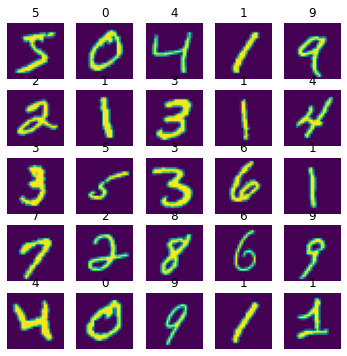

In [4]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.title(fl.train_data['y'][i])
    plt.imshow(fl.train_data['x'][i])

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    FLCustomDataset(fl.train_data['x'],
                    fl.train_data['y'],
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))])
                   ),
    batch_size=configs['runtime']['batch_size'], shuffle=True
)

In [6]:
print(fl.train_data['x'].reshape(-1,784).shape)

(60000, 784)


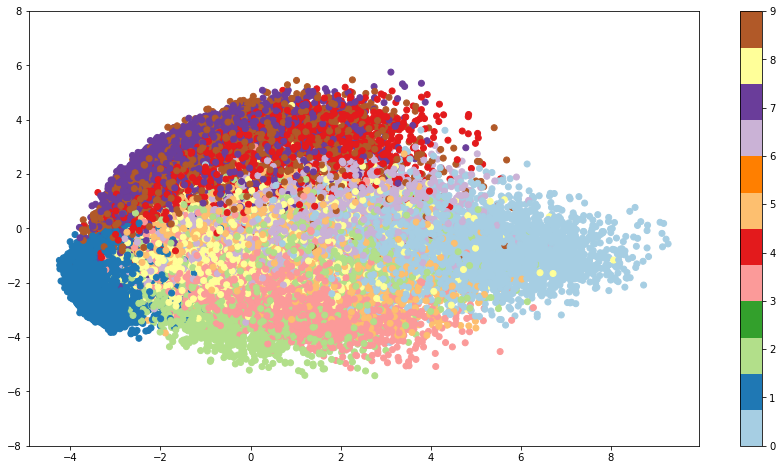

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(fl.train_data['x'].reshape(-1,784))
figure = plt.figure(figsize=(15, 8))
plt.scatter(proj[:, 0], proj[:,1], c = fl.train_data['y'], cmap="Paired")
plt.ylim([-8, 8])
plt.colorbar(ticks=range(10))

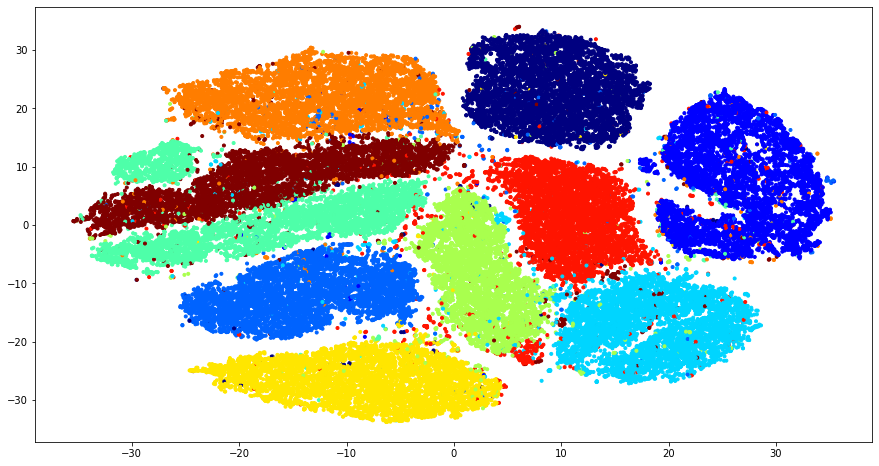

In [8]:
from MulticoreTSNE import MulticoreTSNE as TSNE
embeddings = TSNE(n_jobs=2).fit_transform(fl.train_data['x'].reshape(-1, 784))
figure = plt.figure(figsize=(15,8))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=fl.train_data['y'], cmap=plt.cm.get_cmap("jet", 10), marker=".")
plt.clim(-0.5, 9.5)